<h1 style="color: red">INCOMPLETE DRAFT: DO NOT PUBLICIZE. This document is being made open to facilitate collaboration before completion. Do not publicize it. Comments gratefully accepted.</h1>

# Using consumer digital cameras to facilitate analysis of HNB-based colorimetry on RT-LAMP tests 

## by Andrew D. Straw, University of Freiburg, Faculty of Biology, <a href="mailto:straw@bio.uni-freiburg.de">straw@bio.uni-freiburg.de</a>

### Abstract

Hydroxy naphthol blue (HNB) is a dye that can be used in colorimetric assays to indicate the result of inexpensive LAMP-based diagnostic tests [(Goto et al., 2009)](https://doi.org/10.2144/000113072), including a rapid and sensitive test for SARS-CoV-2 using RT-LAMP [(Kellner et al. 2020)](https://doi.org/10.1101/2020.06.23.166397). Here we ask how to best use digital images of HNB-based SARS-CoV-2 tests. Ideally, image analysis could be completely automated such that reliable and robust classification of reaction results could be made by non-experts and would not require making subjective decisions on potentially subtle visual differences. Because the process is highly visual, experienced observers will be able to validate the automated processing steps.

Below, we use a computational analysis in Python to investigate the use of colorimetry on images from standard consumer digital cameras with the goal of incorporating image acquisition and automated analysis as a part of a reliable, robust, inexpensive and easy to use SARS-CoV-2 testing system with with a minimum of equipment.

Our approach is to predict the appearance of HNB in digital images for both positive and negative reactions. As a validation step, we compare these predictions to photos of HNB. Finally, based on considerations of human color perception, we propose two methods to change the colors of digital images to facilitate manual classification of HNB. The first, "color shift" was proposed by [Kellner et al. 2020](https://doi.org/10.1101/2020.06.23.166397) and, in a hue-saturation-value (HSV) or hue-saturation-lightness HSL space, rotates the hue by 180°. The second, "color stretch" performs a non-linear remapping of the hue space such that expected hues for HNB dyes occupy a larger portion of hue space.

### 1. Absorbance spectra of HNB

We use spectral absorbance curves of HNB [(Goto et al., 2009)](https://doi.org/10.2144/000113072) as the basis of to predicting HNB appearance as a function of LAMP test status. In the course of a positive LAMP reaction, Mg2+ concentration in solution decreases and, correspondingly, the visible appearance of the test result changes from violet to sky blue. However, these appearance changes are subjective and may be subtle for inexperienced observers.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage.color
import skimage.io

In [2]:
# Load absorbance curves of HNB.

# Data from Goto et al. 2009, digitized with WebPlotDigitizer https://apps.automeris.io/wpd/
hnb_Mg_0mM = pd.read_csv("hnb_Mg_0mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 0 mM"], index_col=0)
hnb_Mg_4mM = pd.read_csv("hnb_Mg_4mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 4 mM"], index_col=0)
hnb_Mg_7mM = pd.read_csv("hnb_Mg_7mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 7 mM"], index_col=0)
hnb_Mg_8mM = pd.read_csv("hnb_Mg_8mM.csv",names=["wavelength","Absorbance, HNB, Mg2+ 8 mM"], index_col=0)

In [3]:
# Merge all dataframes according to wavelength and interpolate

absorbance_df = pd.merge_ordered(left=hnb_Mg_0mM, right=hnb_Mg_4mM, on='wavelength')
absorbance_df = pd.merge_ordered(left=absorbance_df, right=hnb_Mg_7mM, on='wavelength')
absorbance_df = pd.merge_ordered(left=absorbance_df, right=hnb_Mg_8mM, on='wavelength')

absorbance_df.set_index('wavelength',inplace=True)
absorbance_df.interpolate(inplace=True, method='index', limit_area='inside')

In [4]:
# Convert absorbance to transmittance and put in new DataFrame `df`.

def convert(colname, indf):
    absorbance = indf[colname]
    col = np.power(10.0,-absorbance.values)
    a = "Absorbance, "
    assert colname.startswith(a)
    b = colname[:]
    b = b[len(a):]
    return b, col

data = {}
for colname in absorbance_df.columns:
    new_name, col = convert(colname, absorbance_df)
    data[new_name] = col
data['wavelength'] = absorbance_df.index
df = pd.DataFrame(data)
df.set_index('wavelength',inplace=True)
del data

<IPython.core.display.Javascript object>


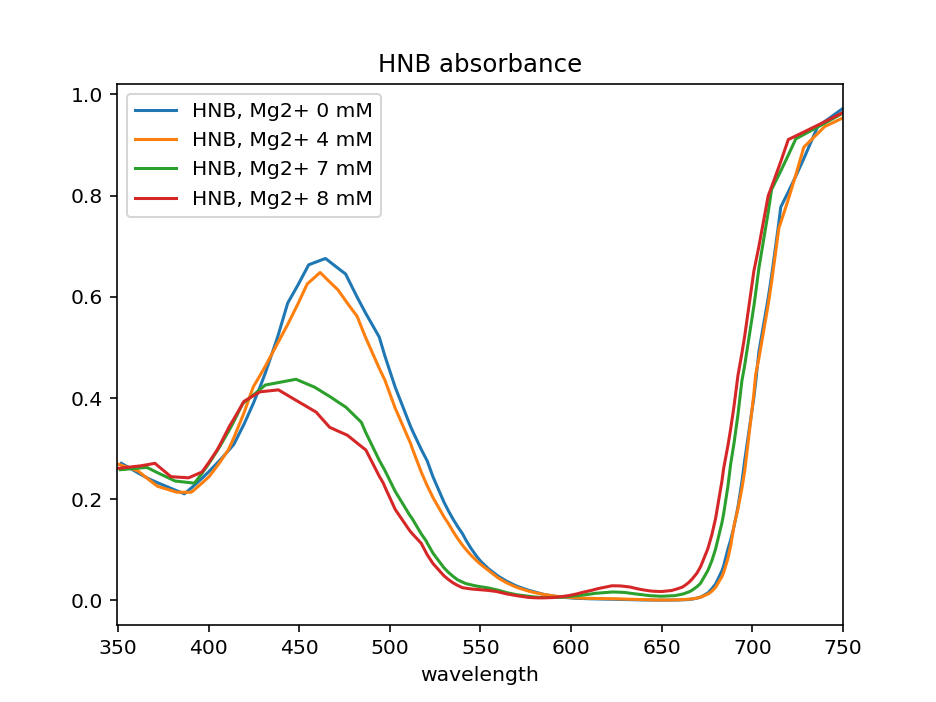

In [5]:
df.plot(title="HNB absorbance");

### 2. Spectral of sensitivities of camera

We use spectral response properties of a digital image sensor (the Sony IMX219) and the spectrum of simulated sunlight as representative of real world consitions.

In [6]:
# Load camera curves.

# Data from https://raw.githubusercontent.com/khufkens/pi-camera-response-curves/master/Sony_IMX219_spectral_response.csv
camera = pd.read_csv("Sony_IMX219_spectral_response.csv", index_col=0)
camera.index = camera.index.astype(float)
camera /= 100.0

# A manual check against data at http://www.gujinwei.org/research/camspec/ confirms the general
# shape of the spectral response of this sensor is similar to that many other digital cameras.

<IPython.core.display.Javascript object>


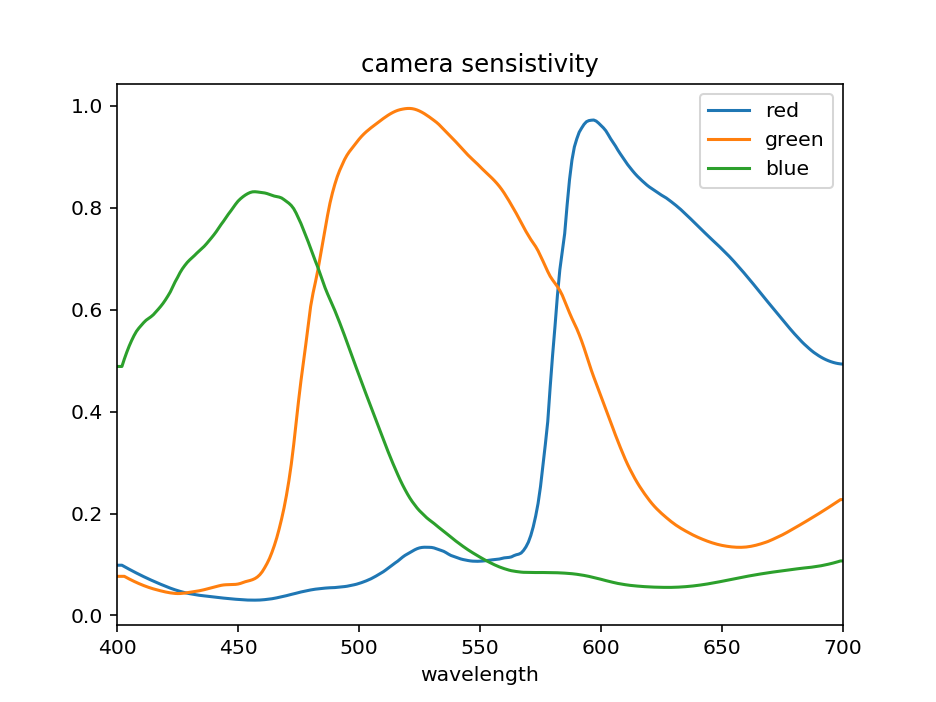

In [7]:
camera.plot(title="camera sensistivity");

In [8]:
# Merge absorbance data with camera data according to wavelength and interpolate
df = pd.merge_ordered(left=df, right=camera, on='wavelength')

df.set_index('wavelength',inplace=True)
df.interpolate(inplace=True, method='index', limit_area='inside')

### 3. Illumination spectrum

We take the approach of simulating light due to black body radiation at 6504K. This is close to the [standard daylight D65 illuminant](https://en.wikipedia.org/wiki/Illuminant_D65).

In [9]:
# Black body spectrum (Planck's Law).

# Modified from https://github.com/axr6077/ParticleTrajectory/blob/dce4e5ee9f1492ccc4816632c7dbf0d47651e7e6/Python%20Scripts/spectrum.py
def black_body(wavelengths, T):
    from scipy.constants import h, c, k

    l = wavelengths * 1e-9
    energy_density = 2 * h * c ** 2 / l ** 5 * 1.0 / (np.exp(h * c / (l * k * T)) - 1.0)
    energy_density /= np.max(energy_density)
    return energy_density

In [10]:
# Calculate illuminant spectrum
df["6504K"] = black_body(df.index.values,6504)

<IPython.core.display.Javascript object>


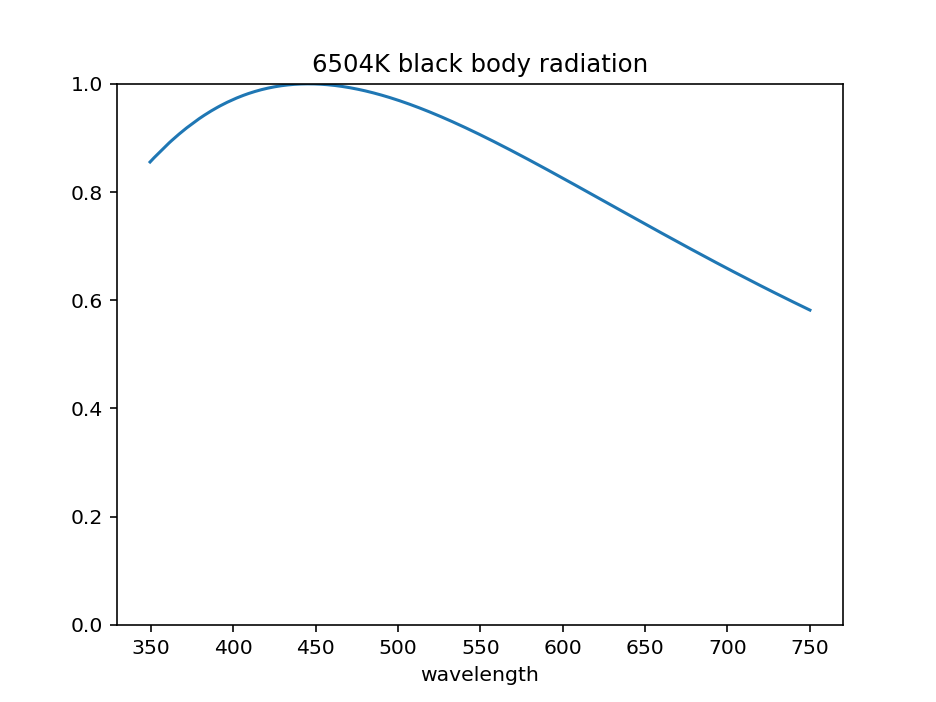

In [11]:
fig, ax = plt.subplots();
ax.plot(df.index.values, df["6504K"].values)
ax.set_xlabel("wavelength")
ax.set_title("6504K black body radiation")
ax.set_ylim(0,1);

In [12]:
# Reindex to ensure uniform spacing along wavelengths.
df = df.reindex(np.arange(350, 750))

### 4. Predict HNB appearance in digital images

So now we have three types of spectral distributions:

- HNB dye transmittance
- digital image sensor sensitivity
- simulated illumination

Based on these spectra, we will predict the RGB values of a digital image of HNB in daylight. To do so, we the quantum catch for each channel

$f_i(λ) = \int\limits_{λ}S(λ)C_i(λ)L(λ)dλ$

where $i$ is the channel (red, green, or blue), $λ$ is the wavelength, and the spectral distributions of HNB $S$, the camera sensitivity $C$ and the illuminant $L$.

One we have computed the quantum catch, we convert to sRGB, by encoding the linear intensity we calculated with the standard gamma function.

In [13]:
# Calculate quantum catch of each color channel for each concentration.
# We scale these to fall in the range (0,-1).

linear_mg0 = []
linear_mg4 = []
linear_mg7 = []
linear_mg8 = []
for channel in ["red","green","blue"]:
    linear_mg0.append((df["HNB, Mg2+ 0 mM"]*df["6504K"]*df[channel]).sum())
    linear_mg4.append((df["HNB, Mg2+ 4 mM"]*df["6504K"]*df[channel]).sum())
    linear_mg7.append((df["HNB, Mg2+ 7 mM"]*df["6504K"]*df[channel]).sum())
    linear_mg8.append((df["HNB, Mg2+ 8 mM"]*df["6504K"]*df[channel]).sum())

linear_mg0 = np.array(linear_mg0)
linear_mg4 = np.array(linear_mg4)
linear_mg7 = np.array(linear_mg7)
linear_mg8 = np.array(linear_mg8)

scale = 1.0 / np.max(np.array([linear_mg0, linear_mg4, linear_mg7, linear_mg8]))
linear_mg0 *= scale
linear_mg4 *= scale
linear_mg7 *= scale
linear_mg8 *= scale

In [14]:
def gamma_func(arr):
    arr = arr.copy()
    mask = arr > 0.0031308
    arr[mask] = 1.055 * np.power(arr[mask], 1 / 2.4) - 0.055
    arr[~mask] *= 12.92
    np.clip(arr, 0, 1, out=arr)    
    return arr

In [15]:
# convert linear to sRGB
mg0 = gamma_func(linear_mg0)
mg4 = gamma_func(linear_mg4)
mg7 = gamma_func(linear_mg7)
mg8 = gamma_func(linear_mg8)

### 5. Result: predicted hue of HNB

Here we show the hue of our predicted appearange.

In [16]:
# Here we see that, independent of scale factor in sRGB space, the hue and saturation remain constant.
mg0_hue = skimage.color.rgb2hsv([[mg0]])[0,0,0]
mg8_hue = skimage.color.rgb2hsv([[mg8]])[0,0,0]
print("Predicted hue of HNB with 0mM Mg2+: %.2f"%mg0_hue)
print("Predicted hue of HNB with 8mM Mg2+: %.2f"%mg8_hue)

Predicted hue of HNB with 0mM Mg2+: 0.55
Predicted hue of HNB with 8mM Mg2+: 0.59


We see that we expect hue values around 0.55 for Mg2+ concentrations of 0 mM, and 0.60 for Mg2+ concentrations of 8 mM.

While Goto et al. 2009 noted that the visual appearance (the color) of HNB changed with Mg2+ concentration, their quantification method was to measure absorption at a single wavelength (650 nm). 

Here, we are interested in using a digital image sensor from a consumer camera to facilitate classification into "positive" vs "negative". While quantification with a single wavelength is not easily possible with a consumer camera, here we address the question of whether a comparison of intensity between the image color channels can be used to quantify Mg2+ concentration and thus classify the result of a test as positive or negative. Ideally, variation in illumination source, visual background, and digital camera manufacturer and model will have negligible effect on the outcome of the automated image processing.

<IPython.core.display.Javascript object>


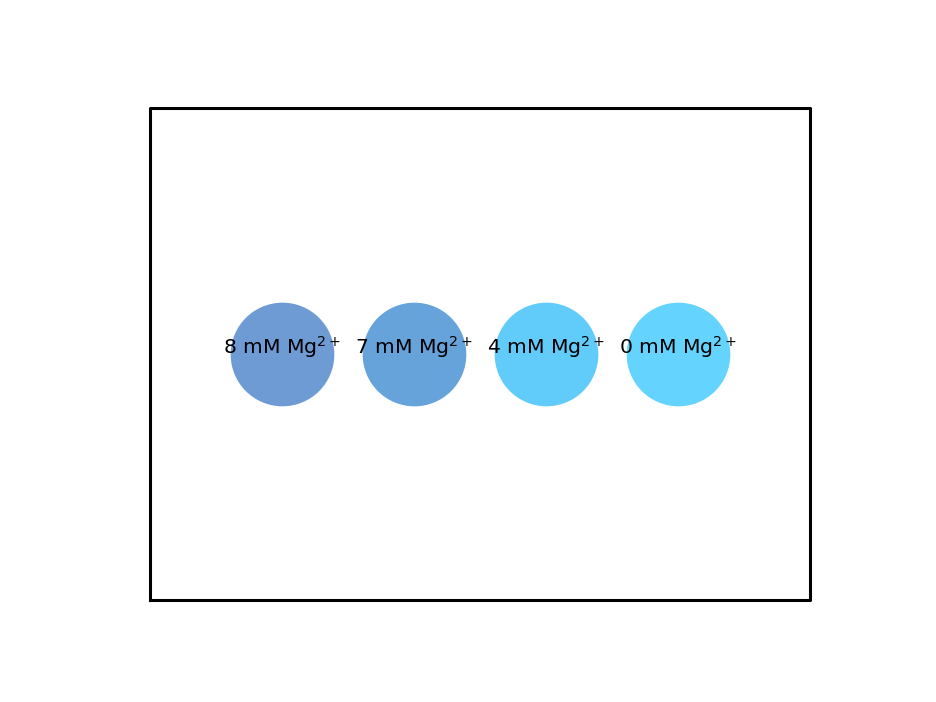

In [17]:
markersize=50.0

fig, ax = plt.subplots(frameon=False)

ax.plot([0.4],[0.1],marker='o',markersize=markersize,color=mg0)
ax.text(0.4,0.1,'0 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([0.3],[0.1],marker='o',markersize=markersize,color=mg4)
ax.text(0.3,0.1,'4 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([0.2],[0.1],marker='o',markersize=markersize,color=mg7)
ax.text(0.2,0.1,'7 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([.1],[0.1],marker='o',markersize=markersize,color=mg8)
ax.text(.1,0.1,'8 mM Mg$^{2+}$',horizontalalignment='center')

ax.plot([0.0, 0.5, 0.5, 0.0, 0.0],[0.0, 0.0, 0.2, 0.2, 0.0],'k-')

ax.axis('off');

Note that the lightness of the circles in the plot is arbitrary. We are concerned with the hue here.

The intensities we calculated of the HNB dye at various Mg2+ concentrations was predicted using simulated daylight. For this analysis, we did not consider alternative illuminants nor any white balance applied by a camera. This is equivalent to assuming that any automatic white balance function in the camera functioned perfectly in compensating any deviation of the illuminant from standard daylight. We do not consider here the effects of this assumption being false and this is left for future work. For now, we consider the predicted hue computed as above as predictive of real world values.

### 6. Comparing predicted hue with hue from real images

I have cropped some images closely around the samples. Let's plot histograms for each image of the hue values as computed by scikit-image.

![Goto-et-al-2009-Fig1-tube-b.png](Goto-et-al-2009-Fig1-tube-b.png) ![Goto-et-al-2009-Fig1-tube-g.png](Goto-et-al-2009-Fig1-tube-g.png) ![Kellner-2020-Fig5D-orf1ab-dip-neg.png](Kellner-2020-Fig5D-orf1ab-dip-neg.png) ![Kellner-2020-Fig5D-orf1ab-dip-pos.png](Kellner-2020-Fig5D-orf1ab-dip-pos.png)

We expect bimodal histograms in which "background" pixels (white or gray in the image) form one peak and "result" pixels ranging from violet to sky blue to form the other peak.

<IPython.core.display.Javascript object>


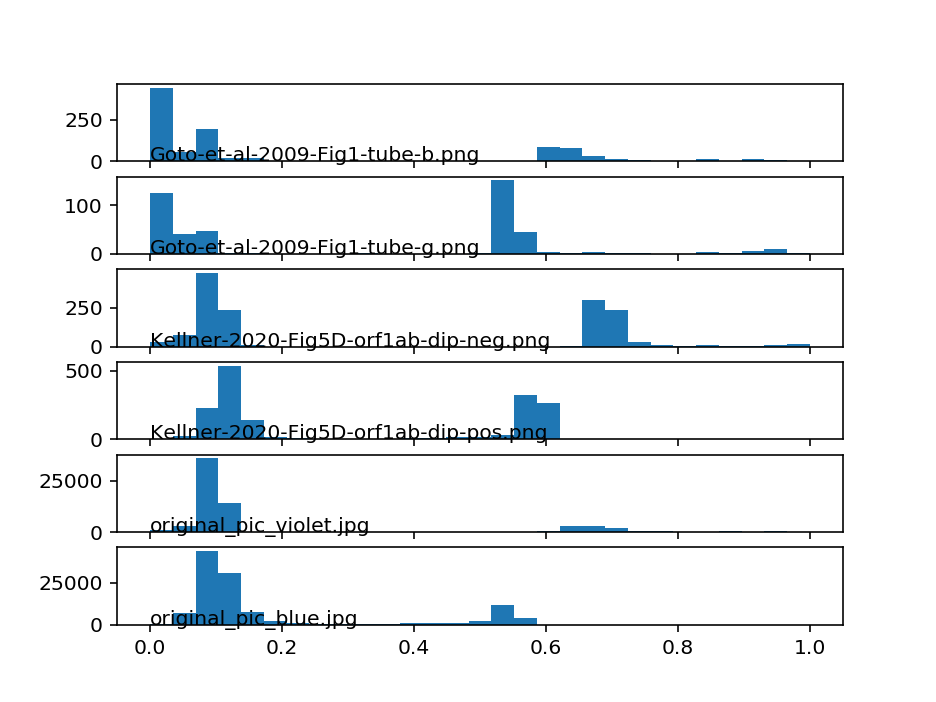

In [18]:
image_filenames = ["Goto-et-al-2009-Fig1-tube-b.png","Goto-et-al-2009-Fig1-tube-g.png",
          "Kellner-2020-Fig5D-orf1ab-dip-neg.png","Kellner-2020-Fig5D-orf1ab-dip-pos.png", "original_pic_violet.jpg", "original_pic_blue.jpg"]
fig, axes = plt.subplots(nrows=len(image_filenames), sharex=True)
bins = np.linspace(0.0, 1.0, 30)
for fname, ax in zip(image_filenames,axes):
    arr = skimage.io.imread(fname)
    hsv = skimage.color.rgb2hsv(arr)
    hues = hsv[:,:,0]
    ax.hist(hues.flat, bins=bins)
    ax.text(bins[0],0,fname)

Indeed, we see two predicted peaks in each histogram. Let's plot only the hues in the interval (0.5,0.7), as this is the range of HNB. Let's also show our theoretical predicted hues.

<IPython.core.display.Javascript object>


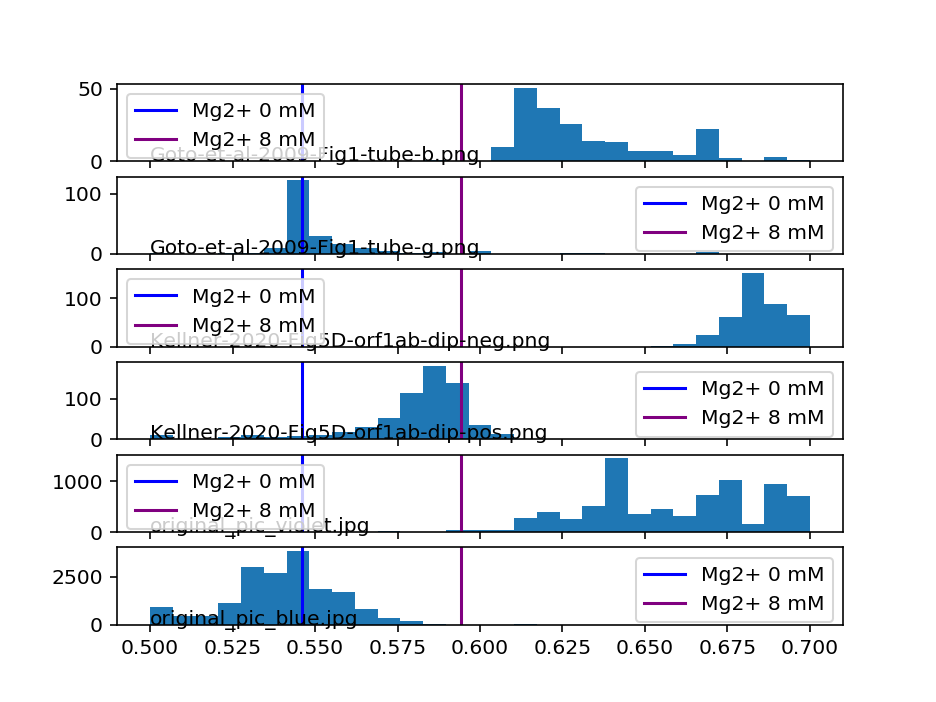

In [19]:
fig, axes = plt.subplots(nrows=len(image_filenames), sharex=True)
bins = np.linspace(0.5, 0.7, 30)
for fname, ax in zip(image_filenames,axes):
    arr = skimage.io.imread(fname)
    hsv = skimage.color.rgb2hsv(arr)
    hues = hsv[:,:,0]
    ax.hist(hues.flat, bins=bins)
    ax.axvline(mg0_hue, label='Mg2+ 0 mM', color='blue')
    ax.axvline(mg8_hue, label='Mg2+ 8 mM', color='purple')
    ax.text(bins[0],0,fname)
    ax.legend()

### 7. A hue threshold to distinguish positive from negative test results

For the images `Goto-et-al-2009-Fig1-tube-b.png` and `original_pic_blue.jpg`, our predicted hue closely matches the hues from these images, which should have low Mg2+ concentration. The image `Kellner-2020-Fig5D-orf1ab-dip-pos.png`, however, has a hue closer to that predicted for high Mg2+ concentrations, even though it should have a low concentration. The other images, with high Mg2+ conentrations, have hues larger hues than predicted.

So, it seems our theoretical predictions do not match the empirical data. Perhaps this is a result of the white balance assumption not being met. Nevertheless, we can continue by using the real-world image hues rather than our prediction of them.

Based on these histograms of real-world image hues, **a hue of 0.60 would be good as a threshold for discriminating positive and negative test results**.

We note that we are using scikit-image definition of hue, and other software may define hue differently. To facilitate conversion to other software, we also convert this to a few sRGB values for this hue with different saturation and brightness.

In [20]:
hue_threshold = 0.6

hsvs = []
for saturation in (0.2, 0.8):
    for value in (0.2, 0.8):
        hsvs.append((hue_threshold, saturation, value))
hsvs = np.array(hsvs)
rgbs = np.round(skimage.color.hsv2rgb([hsvs])[0]*255.0).astype(np.uint8)

print("example sRGB values with hue 0.6:")
print(rgbs)

example sRGB values with hue 0.6:
[[ 41  45  51]
 [163 180 204]
 [ 10  27  51]
 [ 41 106 204]]


### 8. Analysis of "color switch" method

(TODO: write this section) Quick summary: takes advantage of units "hue" not being perceptually uniform and rotates the hue so that HNB colors are shifted into chromaticies in which humans are more sensitive.

### 9. Proposal of "color stretch" method

(TODO: write this section) Quick summary: stretches color space around hues of interest. Desired to be robust to variations in illuminant and white balance in cameras.

In [21]:
def stretch_hues(hues):
    center = 0.6
    r = 0.8

    # get cartesian coordinates for hue
    hue_x = np.cos(hues*np.pi*2)
    hue_y = np.sin(hues*np.pi*2)
    
    # get a new center near the hue point we want to stretch
    cx = r*np.cos(center*np.pi*2)
    cy = r*np.sin(center*np.pi*2)
    
    # compute cartesian coordinates of new hue
    dx = hue_x - cx
    dy = hue_y - cy
    # convert to circular coords for hue
    hues_stretch = np.arctan2(dy, dx)/(2*np.pi)
    hues_stretch = np.mod(hues_stretch, 1.0)
    return hues_stretch

<IPython.core.display.Javascript object>


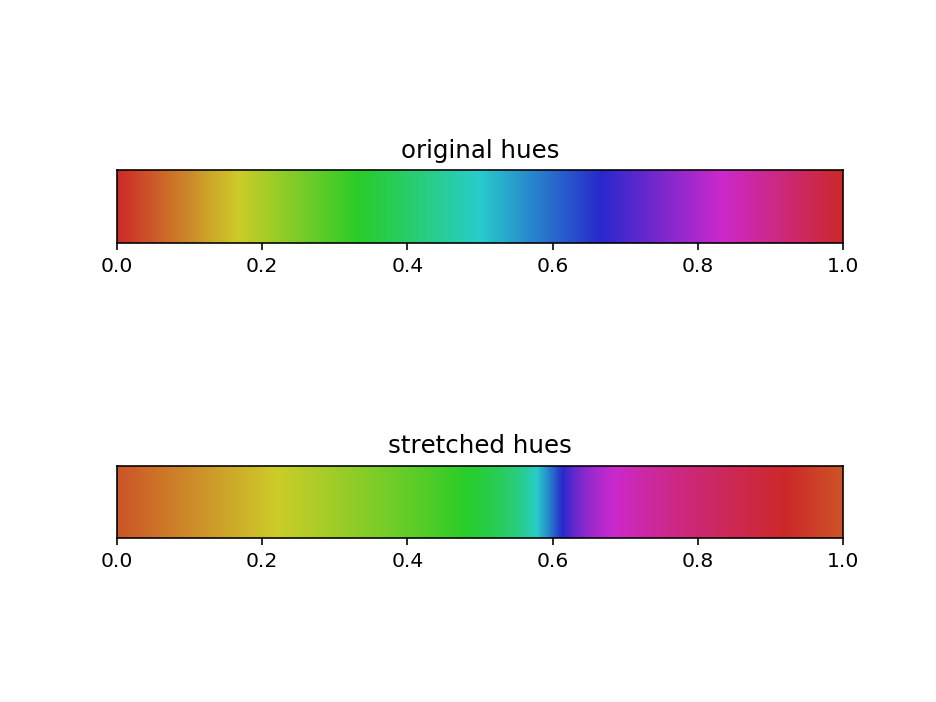

In [22]:
width = 1000
height = 1
hues_orig = np.linspace(0.0, 1.0, width)
hues_stretched = stretch_hues(hues_orig)

hsvs_orig = 0.8*np.ones((height,width,3))
hsvs_stretched = 0.8*np.ones((height,width,3))
for i in range(height):
    hsvs_orig[i,:,0] = hues_orig
    hsvs_stretched[i,:,0] = hues_stretched
rgb_orig = skimage.color.hsv2rgb(hsvs_orig)
rgb_stretched = skimage.color.hsv2rgb(hsvs_stretched)

extent = (0,1,0,.1)

fig, axes = plt.subplots(nrows=2)
ax = axes[0]
ax.imshow(rgb_orig,extent=extent)
ax.set_yticks([])
ax.set_title("original hues")

ax = axes[1]
ax.imshow(rgb_stretched,extent=extent)
ax.set_yticks([])
ax.set_title("stretched hues");

In [23]:
def colorstretch_image(fname):
    arr = skimage.io.imread(fname)
    hsv = skimage.color.rgb2hsv(arr)
    hues = hsv[:,:,0]

    hsv[:,:,0] = stretch_hues(hues)
    hsv[:,:,1] *= 4
    hsv[:,:,1] = np.clip(hsv[:,:,1], 0, 1)

    arr_stretch = skimage.color.hsv2rgb(hsv)
    
    fig, axes = plt.subplots(ncols=2,sharex=True,sharey=True)

    ax1 = axes[0]
    ax1.imshow(arr_stretch)
    ax1.set_title("color stretch")

    ax2 = axes[1]
    ax2.imshow(arr);
    ax2.set_title("original");

<IPython.core.display.Javascript object>


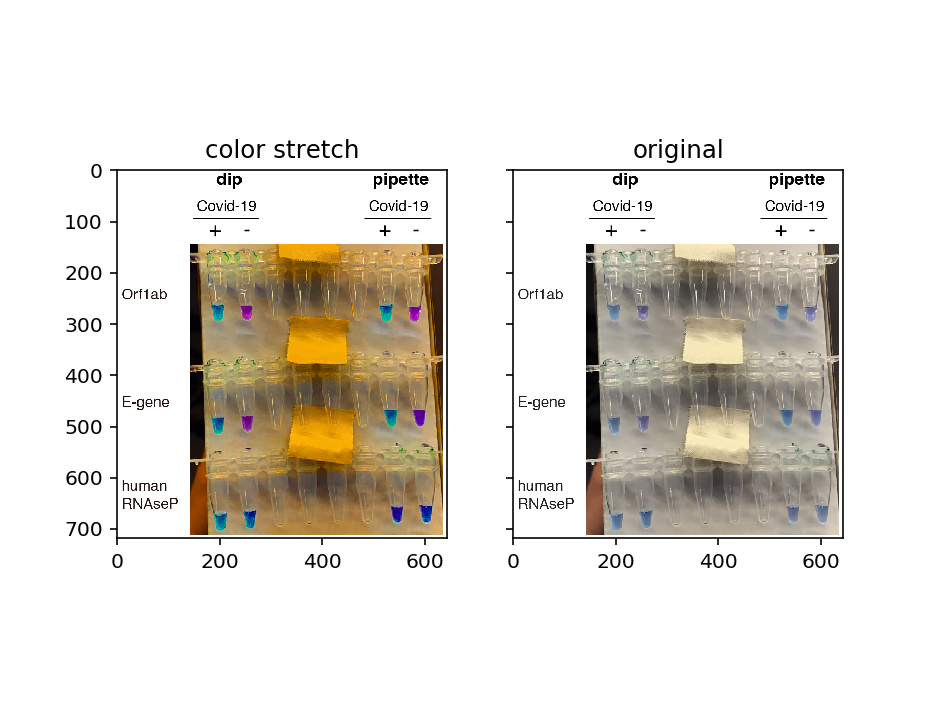

In [24]:
colorstretch_image("Kellner-2020-Fig5D.png")

<IPython.core.display.Javascript object>


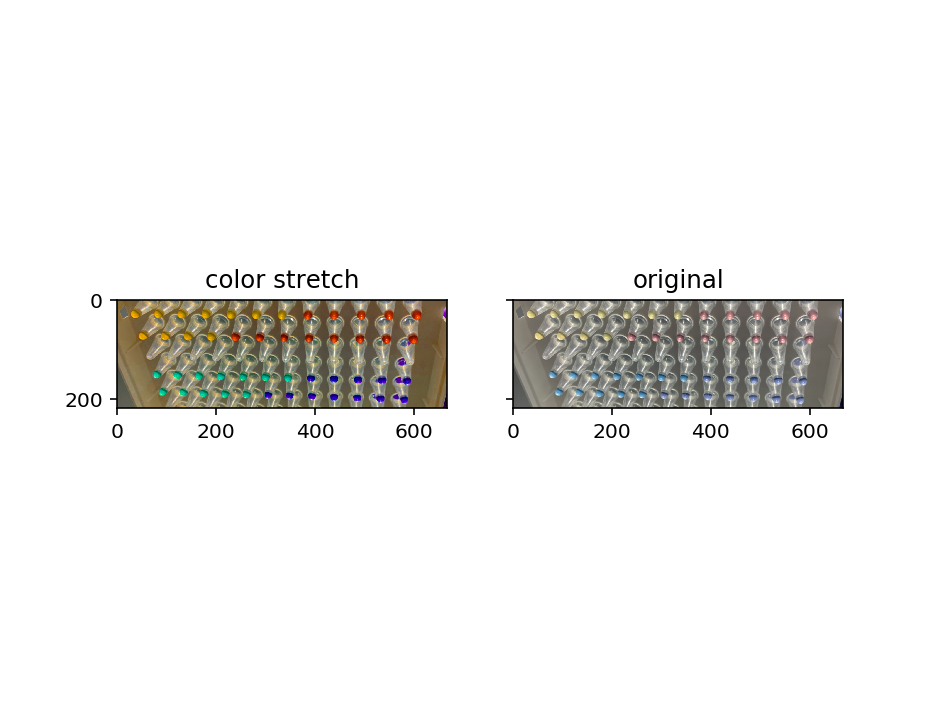

In [25]:
colorstretch_image("Kellner-2020-Fig3a-water.png")

<IPython.core.display.Javascript object>


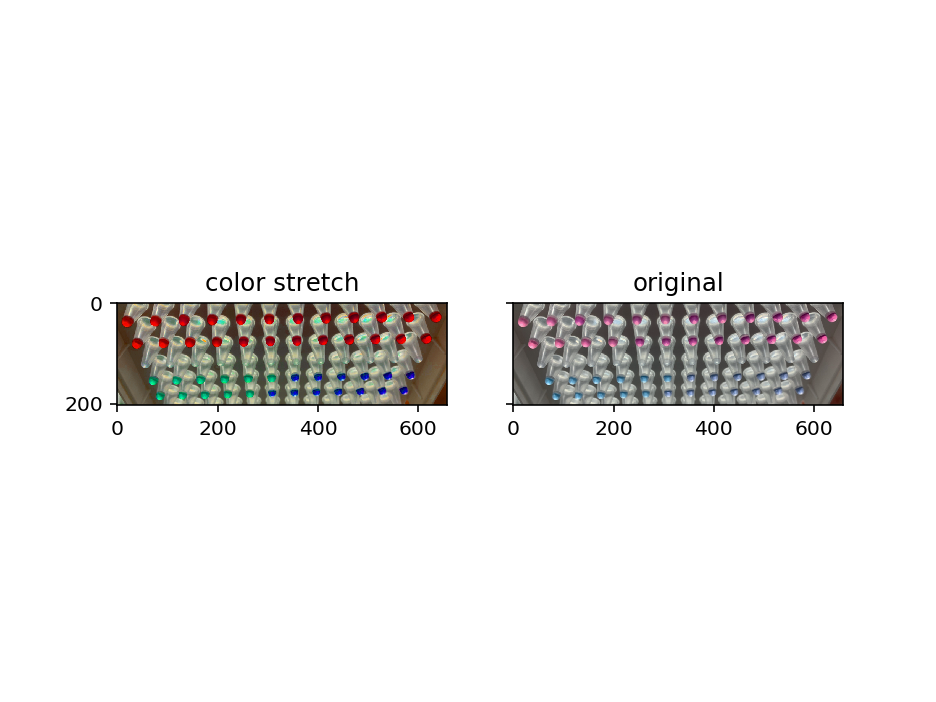

In [26]:
colorstretch_image("Kellner-2020-FigS3a-qe.png")

### 10. An attempt at an automatic classifier based on hue

(TODO: write this section.) Quick summary: this doesn't work all that well.

In [27]:
def classify_image(fname):
    center = 0.6
    margin = 0.015

    arr = skimage.io.imread(fname)
    hsv = skimage.color.rgb2hsv(arr)
    hues = hsv[:,:,0]
    cond_sky_blue = np.logical_and(hues >= 0.5, hues < center-margin)
    cond_violet = np.logical_and(hues >= center+margin, hues < 0.7)

    fig, axes = plt.subplots(ncols=2,sharex=True,sharey=True)

    ax1 = axes[0]
    arr_pos = arr.copy()
    arr_pos[cond_sky_blue] = 255
    ax1.imshow(arr_pos)
    ax1.set_title("white=positive")

    ax2 = axes[1]
    arr_neg = arr.copy()
    arr_neg[cond_violet] = 255
    ax2.imshow(arr_neg);
    ax2.set_title("white=negative");
    #fig.savefig("pixel-classifier.png")

<IPython.core.display.Javascript object>


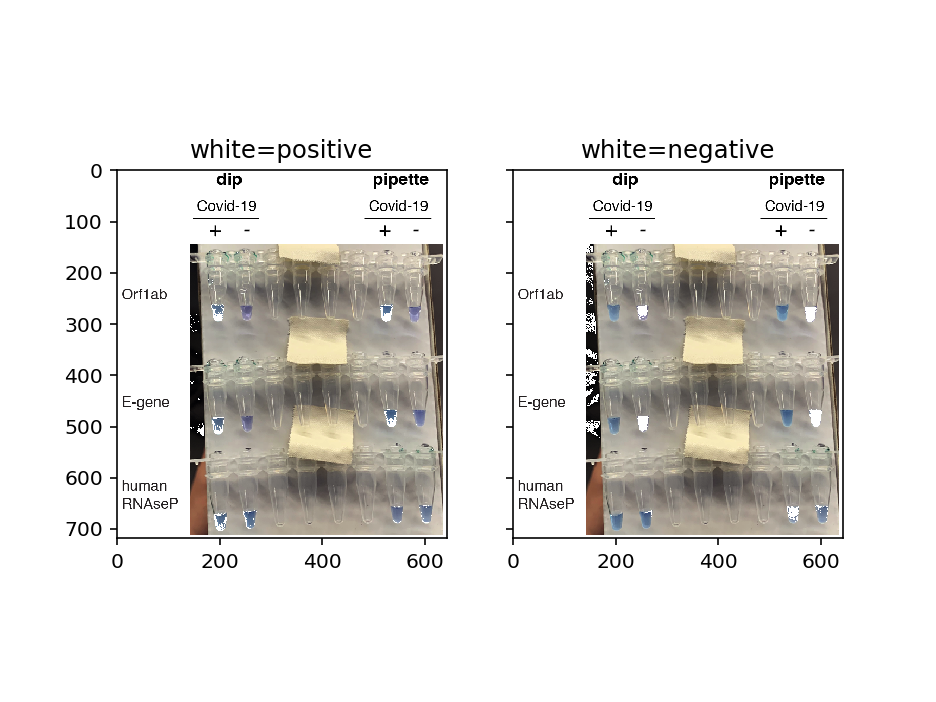

In [28]:
classify_image("Kellner-2020-Fig5D.png")

<IPython.core.display.Javascript object>


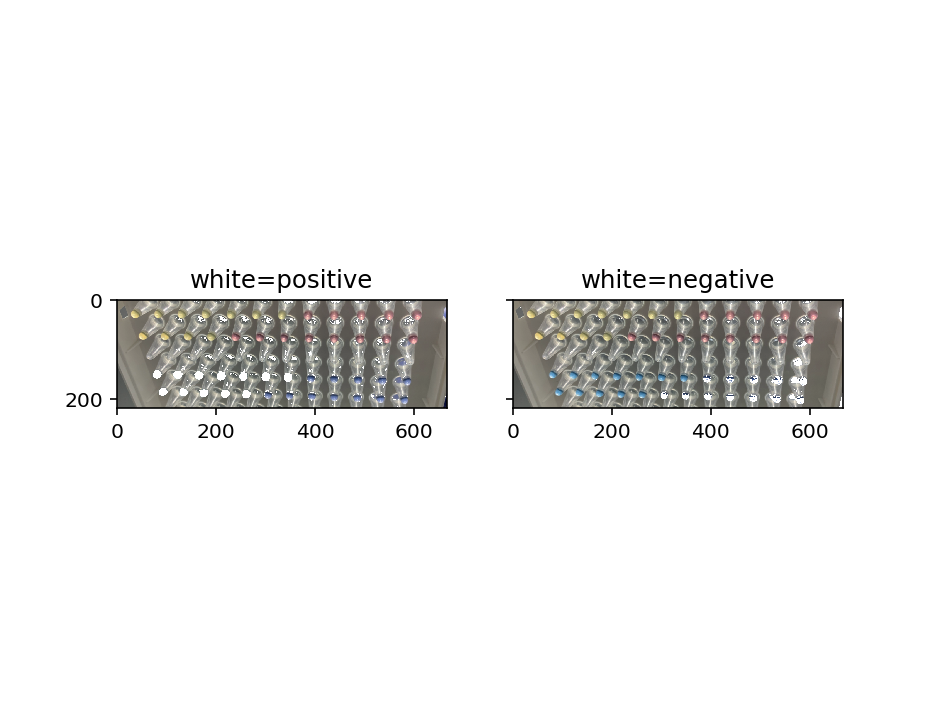

In [29]:
classify_image("Kellner-2020-Fig3a-water.png")

<IPython.core.display.Javascript object>


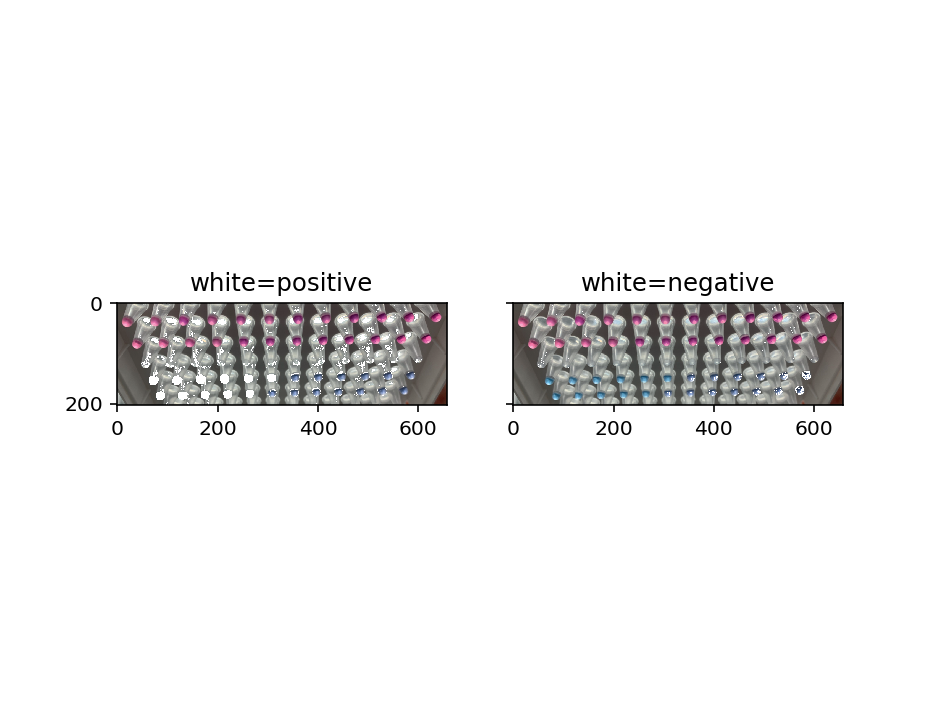

In [30]:
classify_image("Kellner-2020-FigS3a-qe.png")